# Set up

Define work location :

In [3]:
# Define work location
work_loc = 'local'  # colab (google) or local (pc)

Mount Google Drive :

In [4]:
project_path = "My Drive/OPENCLASSROOMS/Projets DATA/6. Classification biens consommation"

if (work_loc == 'colab'):
    # Mount Drive folder
    from google.colab import drive
    drive.mount('/content/drive')

    # Google Drive path
    work_path = "/content/drive/"

elif (work_loc == 'local'):
    # Local drive path
    work_path = "/Users/victor/Library/CloudStorage/GoogleDrive-vicozer@gmail.com/"

else:
    raise ValueError("Choose between 'colab' or 'local' work!")

Python librairies install :

In [5]:
if work_loc == 'colab':
  %pip install transformers

Python librairies imports :

In [6]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

# import tensorflow
import torch
from transformers import TrainingArguments, Trainer
from transformers import BertForSequenceClassification, BertTokenizerFast

import evaluate

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline
sns.set_theme(palette="Set2")

Load pycodestyle (PEP8) :

In [7]:
if (work_loc == 'local'):
    # Pycodestyle (PEP8)
    %load_ext pycodestyle_magic
    %pycodestyle_on --max_line_length 125  # GitHub limit

Load data :

In [58]:
# Load data
clean_df = pd.read_csv("clean_df.csv")
train_df = pd.read_csv("train_df.csv")
test_df = pd.read_csv("test_df.csv")

# Get corpus 
corpus = clean_df['corpus'].to_list()
train_corpus = train_df['corpus'].to_list()
test_corpus = test_df['corpus'].to_list()

# Get labels
labels = clean_df['labels'].to_list()
train_labels = train_df['labels'].to_list()
test_labels= test_df['labels'].to_list()
labels_encoded = clean_df['labels_encoded'].to_list()
train_labels_encoded = train_df['labels_encoded'].to_list()
test_labels_encoded = test_df['labels_encoded'].to_list()

print(train_corpus[:5])
print(test_corpus[:5])

6:13: W291 trailing whitespace
14:12: E225 missing whitespace around operator


['Specifications of Sivanna Baking Powder Rouge  Highlighter (Dark pink brown shimmer 10) General Traits Organic Type Mineral Quantity 12 Shade Dark pink brown shimmer 10 Ideal For Girls, Women Container Type Compact Case Highlighter Traits Multi-shaded Yes Texture Powder based In the Box Highlighter', 'Buy Recon SuperChef Kadhai for Rs.715 online. Recon SuperChef Kadhai at best prices with FREE shipping & cash on delivery. Only Genuine Products. 30 Day Replacement Guarantee.', 'Flipkart.com: Buy Vincent Valentine Paris Set of New Dark & Dark Fire Deodorants Combo Set online only for Rs. 310 from Flipkart.com. Only Genuine Products. 30 Day Replacement Guarantee. Free Shipping. Cash On Delivery!', 'Tatvaarts Elephant Mini ( Fine-Finish) Showpiece  -  8.89 cm (Brass, Gold)\r\n                         Price: Rs. 4,200\r\n\t\t\t\t\r\n\t\t\tElephants are such animals that everybody loves them, be it in reality or in form of toys, paintings, on accessories or artifacts. This is an adorable e

# Functions

In [10]:
# Display histplot
def display_histplot(data, x=None, y=None, title='Histplot', figsize=(12, 8), kde=False):
    plt.figure(figsize=figsize)
    plt.title(title)
    sns.histplot(data=data, x=x, y=y, kde=kde)
    plt.show()

# BERT

## Tokenize the corpus

I create **BERT** tokenizer.

In [59]:
# Create bert tokenizer
bert_tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

loading file vocab.txt from cache at /Users/victor/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/vocab.txt
loading file tokenizer.json from cache at /Users/victor/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /Users/victor/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/tokenizer_config.json
loading configuration file config.json from cache at /Users/victor/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_che

I tokenize the full corpus with the **BERT** tokenizer.

In [60]:
# Tokenize corpus with BERT
corpus_encodings = bert_tokenizer(corpus)

Token indices sequence length is longer than the specified maximum sequence length for this model (577 > 512). Running this sequence through the model will result in indexing errors


I display the distribution of the number of tokens per description to find an optimal description max length.

count    1050.000000
mean      108.136190
std        98.834329
min        19.000000
25%        47.000000
50%        70.000000
75%       129.750000
max       708.000000
dtype: float64

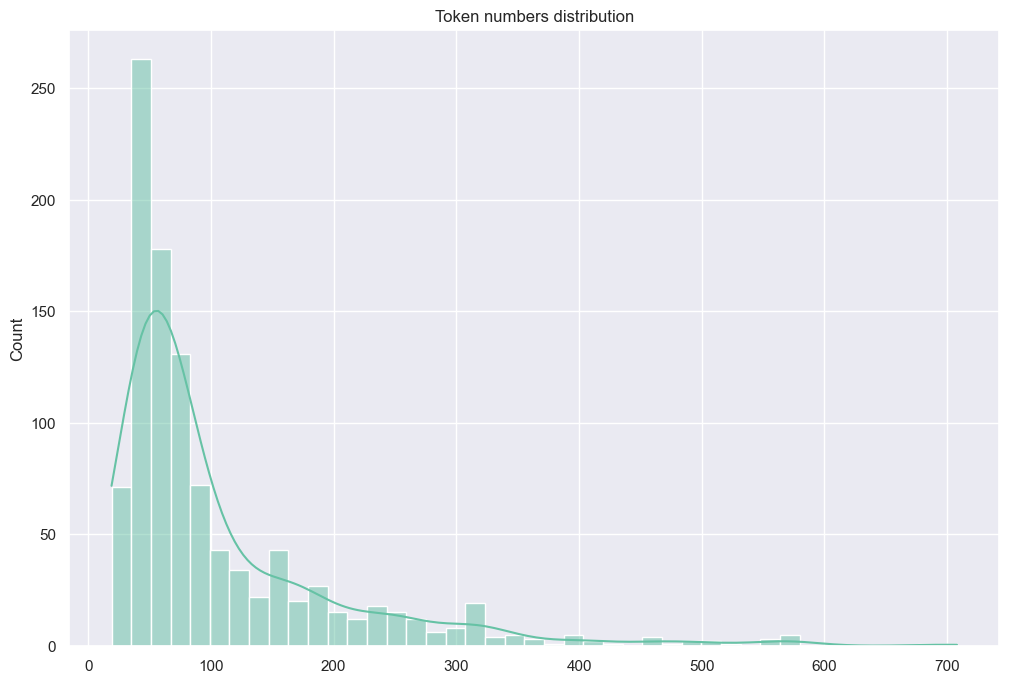

In [61]:
# Get number of tokens
corpus_tokens_number = pd.Series(corpus_encodings['input_ids']).apply(lambda x: len(x))

display(corpus_tokens_number.describe())
display_histplot(corpus_tokens_number, kde=True, title="Token numbers distribution")

I choose to use third quantile as max length.

In [62]:
# Q3 as max length
max_length = int(corpus_tokens_number.quantile(0.75))
print("max length = ", max_length)

max length =  129


I tokenize the training and testing corpus.

In [64]:
# Encode train and test texts
train_encodings = bert_tokenizer(train_corpus, max_length=max_length, truncation=True, padding=True)
test_encodings = bert_tokenizer(test_corpus, max_length=max_length, truncation=True, padding=True)

## Create the datasets

I define a torch Dataset class to create my datasets.

In [65]:
# Custom torch dataset class
class FlipkartDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

I create the torch training and testing sets.

In [66]:
# Create train and test dataset
train_dataset = FlipkartDataset(train_encodings, train_labels_encoded)
test_dataset = FlipkartDataset(test_encodings, test_labels_encoded)

I define the **BERT** model for classification.

In [67]:
# Number of labels
n_labels = pd.Series(labels).nunique()
print("Number of labels =", n_labels)

# Load BertForSequenceClassification
bert_model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=n_labels)

Number of labels = 19


loading configuration file config.json from cache at /Users/victor/.cache/huggingface/hub/models--bert-base-uncased/snapshots/0a6aa9128b6194f4f3c4db429b6cb4891cdb421b/config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15",
    "16": "LABEL_16",
    "17": "LABEL_17",
    "18": "LABEL_18"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_10": 10,
    "LABEL_11": 11,

I define an evaluation function for the model.

In [68]:
# Evaluation function
def bert_compute_metrics(eval_preds):
    metric = evaluate.load("accuracy")
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    return metric.compute(predictions=predictions, references=labels)

## Train the model

I define the training arguments.

In [69]:
# Training arguments
bert_training_args = TrainingArguments(
    output_dir='./bert_results',
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy"
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


I create the torch trainer.

In [70]:
# Torch trainer
bert_trainer = Trainer(
    model=bert_model,
    args=bert_training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=bert_tokenizer,
    compute_metrics=bert_compute_metrics
)

I train the **BERT** model.

In [71]:
# Train the model
bert_trainer.train()

***** Running training *****
  Num examples = 735
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 138
  Number of trainable parameters = 109496851


  0%|          | 0/138 [00:00<?, ?it/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
***** Running Evaluation *****
  Num examples = 315
  Batch size = 16


  0%|          | 0/20 [00:00<?, ?it/s]

Saving model checkpoint to ./bert_results/checkpoint-46
Configuration saved in ./bert_results/checkpoint-46/config.json


{'eval_loss': 2.4034199714660645, 'eval_accuracy': 0.5206349206349207, 'eval_runtime': 19.7932, 'eval_samples_per_second': 15.915, 'eval_steps_per_second': 1.01, 'epoch': 1.0}


Model weights saved in ./bert_results/checkpoint-46/pytorch_model.bin
tokenizer config file saved in ./bert_results/checkpoint-46/tokenizer_config.json
Special tokens file saved in ./bert_results/checkpoint-46/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 315
  Batch size = 16


  0%|          | 0/20 [00:00<?, ?it/s]

Saving model checkpoint to ./bert_results/checkpoint-92
Configuration saved in ./bert_results/checkpoint-92/config.json


{'eval_loss': 1.9956859350204468, 'eval_accuracy': 0.638095238095238, 'eval_runtime': 19.832, 'eval_samples_per_second': 15.883, 'eval_steps_per_second': 1.008, 'epoch': 2.0}


Model weights saved in ./bert_results/checkpoint-92/pytorch_model.bin
tokenizer config file saved in ./bert_results/checkpoint-92/tokenizer_config.json
Special tokens file saved in ./bert_results/checkpoint-92/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 315
  Batch size = 16


  0%|          | 0/20 [00:00<?, ?it/s]

Saving model checkpoint to ./bert_results/checkpoint-138
Configuration saved in ./bert_results/checkpoint-138/config.json


{'eval_loss': 1.8318103551864624, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 19.7458, 'eval_samples_per_second': 15.953, 'eval_steps_per_second': 1.013, 'epoch': 3.0}


Model weights saved in ./bert_results/checkpoint-138/pytorch_model.bin
tokenizer config file saved in ./bert_results/checkpoint-138/tokenizer_config.json
Special tokens file saved in ./bert_results/checkpoint-138/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from ./bert_results/checkpoint-138 (score: 0.6666666666666666).


{'train_runtime': 585.6626, 'train_samples_per_second': 3.765, 'train_steps_per_second': 0.236, 'train_loss': 2.2912593233412593, 'epoch': 3.0}


TrainOutput(global_step=138, training_loss=2.2912593233412593, metrics={'train_runtime': 585.6626, 'train_samples_per_second': 3.765, 'train_steps_per_second': 0.236, 'train_loss': 2.2912593233412593, 'epoch': 3.0})

I evaluate the trained model.

In [73]:
# Evaluate the model
bert_trainer.evaluate()

***** Running Evaluation *****
  Num examples = 315
  Batch size = 16


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 1.8318103551864624,
 'eval_accuracy': 0.6666666666666666,
 'eval_runtime': 17.558,
 'eval_samples_per_second': 17.941,
 'eval_steps_per_second': 1.139,
 'epoch': 3.0}

I save the trained model.

In [74]:
import os

# Define output_directory
output_dir = './bert_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save trained model
bert_trainer.save_model(output_dir)

Saving model checkpoint to ./bert_save/
Configuration saved in ./bert_save/config.json


Saving model to ./bert_save/


Model weights saved in ./bert_save/pytorch_model.bin
tokenizer config file saved in ./bert_save/tokenizer_config.json
Special tokens file saved in ./bert_save/special_tokens_map.json
